In [1]:

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_use]

In [4]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [5]:
review_df.describe()

,helpful_votes,location_id,review_id,rating
count,5909.000000,5.909000e+03,5.909000e+03,5909.000000
mean,1.058216,6.483167e+06,7.590446e+08,4.153833
std,5.625108,4.877561e+06,1.844114e+08,1.067077
min,0.000000,3.110380e+05,1.049076e+08,1.000000
25%,0.000000,2.578107e+06,6.573250e+08,4.000000
50%,0.000000,6.017599e+06,7.832754e+08,4.000000
75%,1.000000,8.818088e+06,9.240324e+08,5.000000
max,182.000000,2.714283e+07,9.653184e+08,5.000000


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   helpful_votes   5909 non-null   int64 
 1   location_id     5909 non-null   int64 
 2   review_id       5909 non-null   int64 
 3   review          5909 non-null   object
 4   review_subject  5909 non-null   object
 5   trip_type       5892 non-null   object
 6   rating          5909 non-null   int64 
 7   location_name   5909 non-null   object
 8   province        5909 non-null   object
 9   place_id        5909 non-null   object
 10  emotion         5909 non-null   object
 11  cleaned_review  5909 non-null   object
dtypes: int64(4), object(8)
memory usage: 554.1+ KB


In [7]:
df_review_yelp = pd.read_csv("../../dataset/Central_Attraction_Reviews.csv")
df_review_yelp.head(5)

,Unnamed: 0,Attraction,Rating,Review Summary,Review Sentiment,Province
0,1999,Ancient City,1,Wat Chaloem Phra Kiat is a peaceful retreat… u...,Negative,Samut Prakan
1,1588,Ancient City,2,"Samphran Elephant Ground, where the elephants ...",Negative,Samut Prakan
2,1586,Ancient City,2,Ancient City is like walking through a history...,Negative,Samut Prakan
3,1583,Ancient City,2,Koh Kret could be charming if it weren’t for t...,Negative,Samut Prakan
4,1581,Ancient City,1,Erawan Museum has an impressive elephant statu...,Negative,Samut Prakan


In [8]:

custom_review_df = df_review_yelp[["Rating", "Review Summary"]]
new_df_renamed = custom_review_df.rename(columns={"Rating": "label", "Review Summary": "text"})
df_review_yelp = new_df_renamed
df_review_yelp.head(5)

,label,text
0,1,Wat Chaloem Phra Kiat is a peaceful retreat… u...
1,2,"Samphran Elephant Ground, where the elephants ..."
2,2,Ancient City is like walking through a history...
3,2,Koh Kret could be charming if it weren’t for t...
4,1,Erawan Museum has an impressive elephant statu...


In [9]:
import random

def map_label_to_rating(val):
    return val + 1

def map_generate_location_id():
    return f"CUSTOM{random.randint(10000, 99999)}"

df_review_yelp['location_id'] = df_review_yelp['text'].apply(lambda x: map_generate_location_id())
df_review_yelp['review'] = df_review_yelp['text']
df_review_yelp['rating'] = df_review_yelp['label'].apply(map_label_to_rating)

df_review_yelp = df_review_yelp[['rating', 'review', 'location_id']]


In [10]:
df_review_yelp

,rating,review,location_id
0,2,Wat Chaloem Phra Kiat is a peaceful retreat… u...,CUSTOM97232
1,3,"Samphran Elephant Ground, where the elephants ...",CUSTOM24385
2,3,Ancient City is like walking through a history...,CUSTOM85843
3,3,Koh Kret could be charming if it weren’t for t...,CUSTOM16416
4,2,Erawan Museum has an impressive elephant statu...,CUSTOM84706
...,...,...,...
9495,3,Phra Nakhon Khiri is breathtaking... if you do...,CUSTOM75201
9496,2,"Wat Phra Non Chaksi: impressive, but the heat ...",CUSTOM52894
9497,2,Phra Nakhon Khiri is breathtaking... if you do...,CUSTOM90486
9498,5,Wat Muang is absolutely stunning... if you enj...,CUSTOM16226


In [11]:
df_postive_yelp = df_review_yelp[df_review_yelp['rating'].isin([5])]
df_natural_yelp = df_review_yelp[df_review_yelp['rating'].isin([3, 4])]
df_negative_yelp = df_review_yelp[df_review_yelp['rating'].isin([1, 2])]

print(f"Positive [{len(df_postive_yelp)}] / Natural [{len(df_natural_yelp)}] / Negative [{len(df_negative_yelp)}]")

Positive [1074] / Natural [4883] / Negative [2470]


In [27]:
df_postive = review_df[review_df['rating'].isin([5])]
df_natural = review_df[review_df['rating'].isin([3, 4])]
df_negative = review_df[review_df['rating'].isin([1, 2])]

print(f"Positive [{len(df_postive)}] / Natural [{len(df_natural)}] / Negative [{len(df_negative)}]")

Positive [2871] / Natural [2571] / Negative [467]


In [9]:
# binary_url = 'https://github.com/BrownDSI/word2vec-slim/releases/' + \
#              'download/v0.1/GoogleNews-vectors-negative300-slim.bin.gz'
# r = requests.get(binary_url)
# open('google-word2vec-slim.bin.gz', 'wb').write(r.content);

# model = KeyedVectors.load_word2vec_format('google-word2vec-slim.bin.gz', binary = True)

In [10]:
# print(os.path.exists(f"{NLTK_DATA_PATH}/tokenizers/punkt")) 

In [11]:
# 1. Data Preparation
# nltk.download ('all', download_dir=NLTK_DATA_PATH)

In [7]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = "Hello Mr. Smith, how are you doing today? The weather is great and Python is awesome. The sky is pinkish-blue. You should not eat cardboard."
word_tokenize ( text )
sent_tokenize ( text )

['Hello Mr. Smith, how are you doing today?',
 'The weather is great and Python is awesome.',
 'The sky is pinkish-blue.',
 'You should not eat cardboard.']

In [8]:
from nltk.corpus import stopwords 

custom_stopwords = set(stopwords.words('english'))

In [9]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [10]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [26]:
combined_positive_df = pd.concat([df_postive_yelp.iloc[:-len(df_postive)], df_postive])
combined_natural_df = pd.concat([df_natural_yelp.iloc[:-len(df_natural)], df_natural])
combined_negative_df = pd.concat([df_negative_yelp.iloc[:-len(df_negative)], df_negative])

NameError: name 'df_postive_yelp' is not defined

In [12]:
print(f"{len(combined_positive_df)} / {len(combined_natural_df)} / {len(combined_negative_df)}")

NameError: name 'combined_positive_df' is not defined

In [28]:
selected_column_trained = ['rating', 'location_id', 'review']
full_combined_df = pd.concat([df_natural[selected_column_trained], df_postive[selected_column_trained], df_negative[selected_column_trained]])

In [29]:
print(len(full_combined_df))
print(full_combined_df)

5909
      rating  location_id                                             review
1          4      2209612  This is one of the last big king temples of Ba...
2          4      2209612  It is beautiful, clean and free to enter. Both...
10         4       311043  The complex is quite nice, but the gold reclin...
11         4       311043  We all love a fantastic holiday photo to share...
18         4       317504  This is one of the famous temples in Bangkok a...
...      ...          ...                                                ...
5814       1     10000684  Personally tough this place is not maintained ...
5859       1      1390151  Found this on social, the owner parked his/her...
5866       2      6668995  Wat Intharam was apparently built during the A...
5867       2      6668995  if you expect to find authentic buddhist teach...
5882       1       456191  Living in Thailand many years, having Thai hus...

[5909 rows x 3 columns]


In [15]:
# Apply preprocessing to the review texts
full_combined_df['cleaned_review'] = full_combined_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
sentences = [row.split() for row in full_combined_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



In [16]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 300  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [17]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating in [3]:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

In [18]:
full_combined_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))
full_combined_df['sentiment'] = full_combined_df['rating'].apply(map_rating_to_sentiment)

In [19]:
full_combined_df.head(5)

,rating,location_id,review,cleaned_review,embedding,sentiment
1,4,2209612,This is one of the last big king temples of Ba...,one last big king temple bangkok one lot europ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
2,4,2209612,"It is beautiful, clean and free to enter. Both...",beautiful clean free enter exterior interior s...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
10,4,311043,"The complex is quite nice, but the gold reclin...",complex quite nice gold reclining buddha stunn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
11,4,311043,We all love a fantastic holiday photo to share...,love fantastic holiday photo share reflect hom...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
18,4,317504,This is one of the famous temples in Bangkok a...,one famous temple bangkok quite popular among ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive


In [20]:
df_balanced = full_combined_df

In [21]:
from sklearn.utils import resample

# Assuming `review_df` is your original DataFrame with a 'sentiment' column

# 1. Separate the data by class
df_positive = full_combined_df[full_combined_df.sentiment == 'positive']
df_neutral = full_combined_df[full_combined_df.sentiment == 'neutral']
df_negative = full_combined_df[full_combined_df.sentiment == 'negative']

# 2. Resample the minority classes
# For example, oversample the neutral and negative classes to match the positive class
df_neutral_upsampled = resample(df_neutral,
                                replace=True,  # Sample with replacement
                                n_samples=len(df_positive),  # Match number of positive class samples
                                random_state=42)  # Reproducible results

df_negative_upsampled = resample(df_negative,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_positive),  # Match number of positive class samples
                                 random_state=42)  # Reproducible results

# 3. Combine the resampled DataFrames
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# 4. Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)




In [22]:
df_balanced

,rating,location_id,review,cleaned_review,embedding,sentiment
0,3,4322585,This was an ornate wat inside Mae Sot. It is a...,ornate wat inside mae sot burmese style wat ty...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral
1,2,2667297,Got the Asia perfect for body treatment. We re...,got asia perfect body treatment read review th...,"[[-0.0017105329316109419, 0.03534667193889618,...",negative
2,5,447585,The grounds include a number of pavilions and ...,ground include number pavilion building unique...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
3,1,6885224,The visit to this island is worth it just to u...,visit island worth understand tragic result un...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
4,5,4322942,A wonderfull place . A wonderfull monk lived t...,wonderfull place wonderfull monk lived may bei...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
...,...,...,...,...,...,...
14062,3,7287889,It is not as pretty as some picture lead to be...,pretty picture lead believe big either minute ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral
14063,1,10631803,The whole trip was spoilt by lying local tour ...,whole trip spoilt lying local tour package sel...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",negative
14064,3,1368429,"As a keen biker, I was excited to experience t...",keen biker excited experience breathtaking sce...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral
14065,4,10865484,The waterfall was flowing quite well.\n\nSever...,waterfall flowing quite well several group dec...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive


In [27]:
# full_combined_df.to_csv("../dataset/full_embled_review_combined.csv")

In [39]:
# df_balanced = full_combined_df

# print(df_balanced['sentiment'].value_counts())

sentiment
neutral     4883
positive    2871
negative    2470
Name: count, dtype: int64


In [84]:
df_balanced['location_id_numeric'] = pd.to_numeric(df_balanced['location_id'], errors='coerce')

# Filter out rows where 'location_id_numeric' is NaN (i.e., non-integer)
filtered_df = df_balanced[df_balanced['location_id_numeric'].notna()]
trained_df = df_balanced[df_balanced['location_id_numeric'].isna()] 

# Drop the helper 'location_id_numeric' column if you don't need it anymore
validate_review_df = filtered_df.drop(columns=['location_id_numeric'])
training_review_df = trained_df.drop(columns=['location_id_numeric'])


In [85]:
min_size = training_review_df.groupby('sentiment').size().min()

df_sampled = training_review_df.groupby('sentiment').apply(lambda x: x.sample(n=min_size, random_state=42)).reset_index(drop=True)


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_4157/3261891692.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = training_review_df.groupby('sentiment').apply(lambda x: x.sample(n=min_size, random_state=42)).reset_index(drop=True)


In [23]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [24]:
X.shape

(14067, 300)

In [25]:
y.shape

(14067,)

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (9846, 300)
y_train shape: (9846,)
X_test shape: (4221, 300)
y_test shape: (4221,)


In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

# Step 6: Build the LSTM Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 
max_len = 100

# สร้างโมเดลด้วย L2 Regularization และ Dropout
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))  # L2 Regularization
model.add(Dropout(0.5))
model.add(LSTM(64, kernel_regularizer=l2(0.01)))  # L2 Regularization
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # สมมติว่ามี 3 คลาส


optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [34]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [35]:
class_weights_dict = dict(enumerate(class_weights))

In [36]:
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0}

In [37]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir=f'../../logs')

In [105]:
import mlflow
import mlflow.keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

# Set up MLflow experiment
mlflow.set_experiment("LSTM_model_experiment")

# Start MLflow run
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("epochs", 50)  # Changed to 50 since you are using 50 epochs
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("patience", 10)

    # Define EarlyStopping and ModelCheckpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('../../models/LSTM_models_sample.keras', monitor='val_loss', save_best_only=True)
    
    # Train model
    history = model.fit(X_train_resampled, y_train_resampled,
                        epochs=50,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, model_checkpoint, tensorboard],
                        class_weight=None)  # Set to None or omit entirely
    
    # Log model metrics
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("train_accuracy", history.history.get('accuracy', [0])[-1])
    mlflow.log_metric("val_accuracy", history.history.get('val_accuracy', [0])[-1])

    # Log the Keras model
    mlflow.keras.log_model(model, "models/LSTM_model")

    # Log model checkpoint path
    mlflow.log_artifact('../../models/LSTM_models_sample.keras', artifact_path='model_checkpoint')

# End MLflow run
mlflow.end_run()


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.5719 - loss: 2.1779 - val_accuracy: 0.6885 - val_loss: 0.7051
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.7319 - loss: 0.6638 - val_accuracy: 0.7519 - val_loss: 0.5644
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.8880 - loss: 0.3713 - val_accuracy: 0.7806 - val_loss: 0.5745
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 364ms/step - accuracy: 0.9478 - loss: 0.2298 - val_accuracy: 0.7918 - val_loss: 0.6039
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9690 - loss: 0.1576 - val_accuracy: 0.7790 - val_loss: 0.7007
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.9793 - loss: 0.1278 - val_accuracy: 0.7717 - val_loss: 0.9329
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.9823 - loss: 0.0999 - val_accuracy: 0.7968 - val_loss: 0.8995
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 357ms/step - accuracy: 0.9871 - loss: 0.0889 - val_accu

2024/10/02 09:57:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/02 09:57:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [60]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/LSTM_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, tensorboard],
                    class_weight=None)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9973 - loss: 0.0401

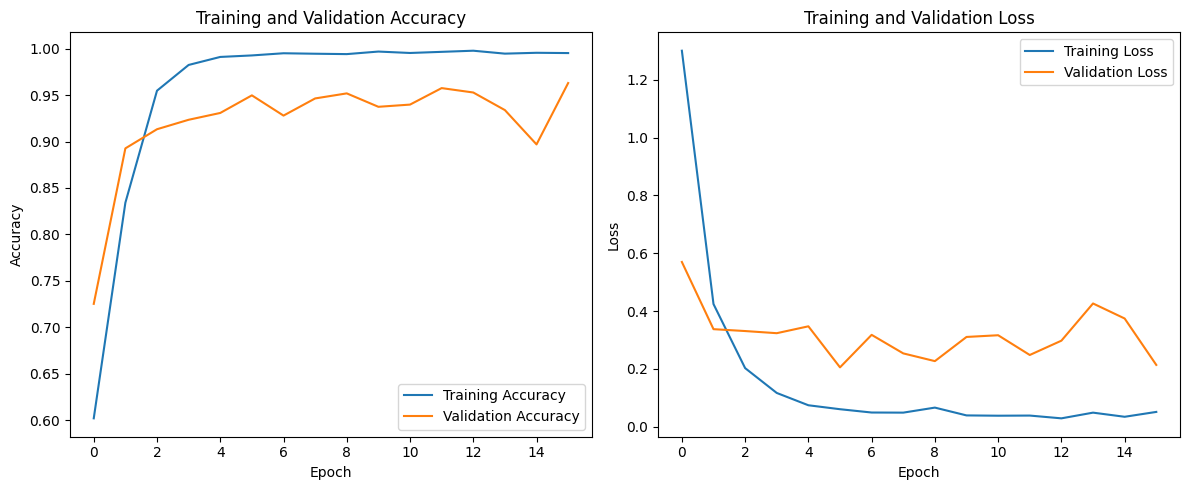

In [39]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

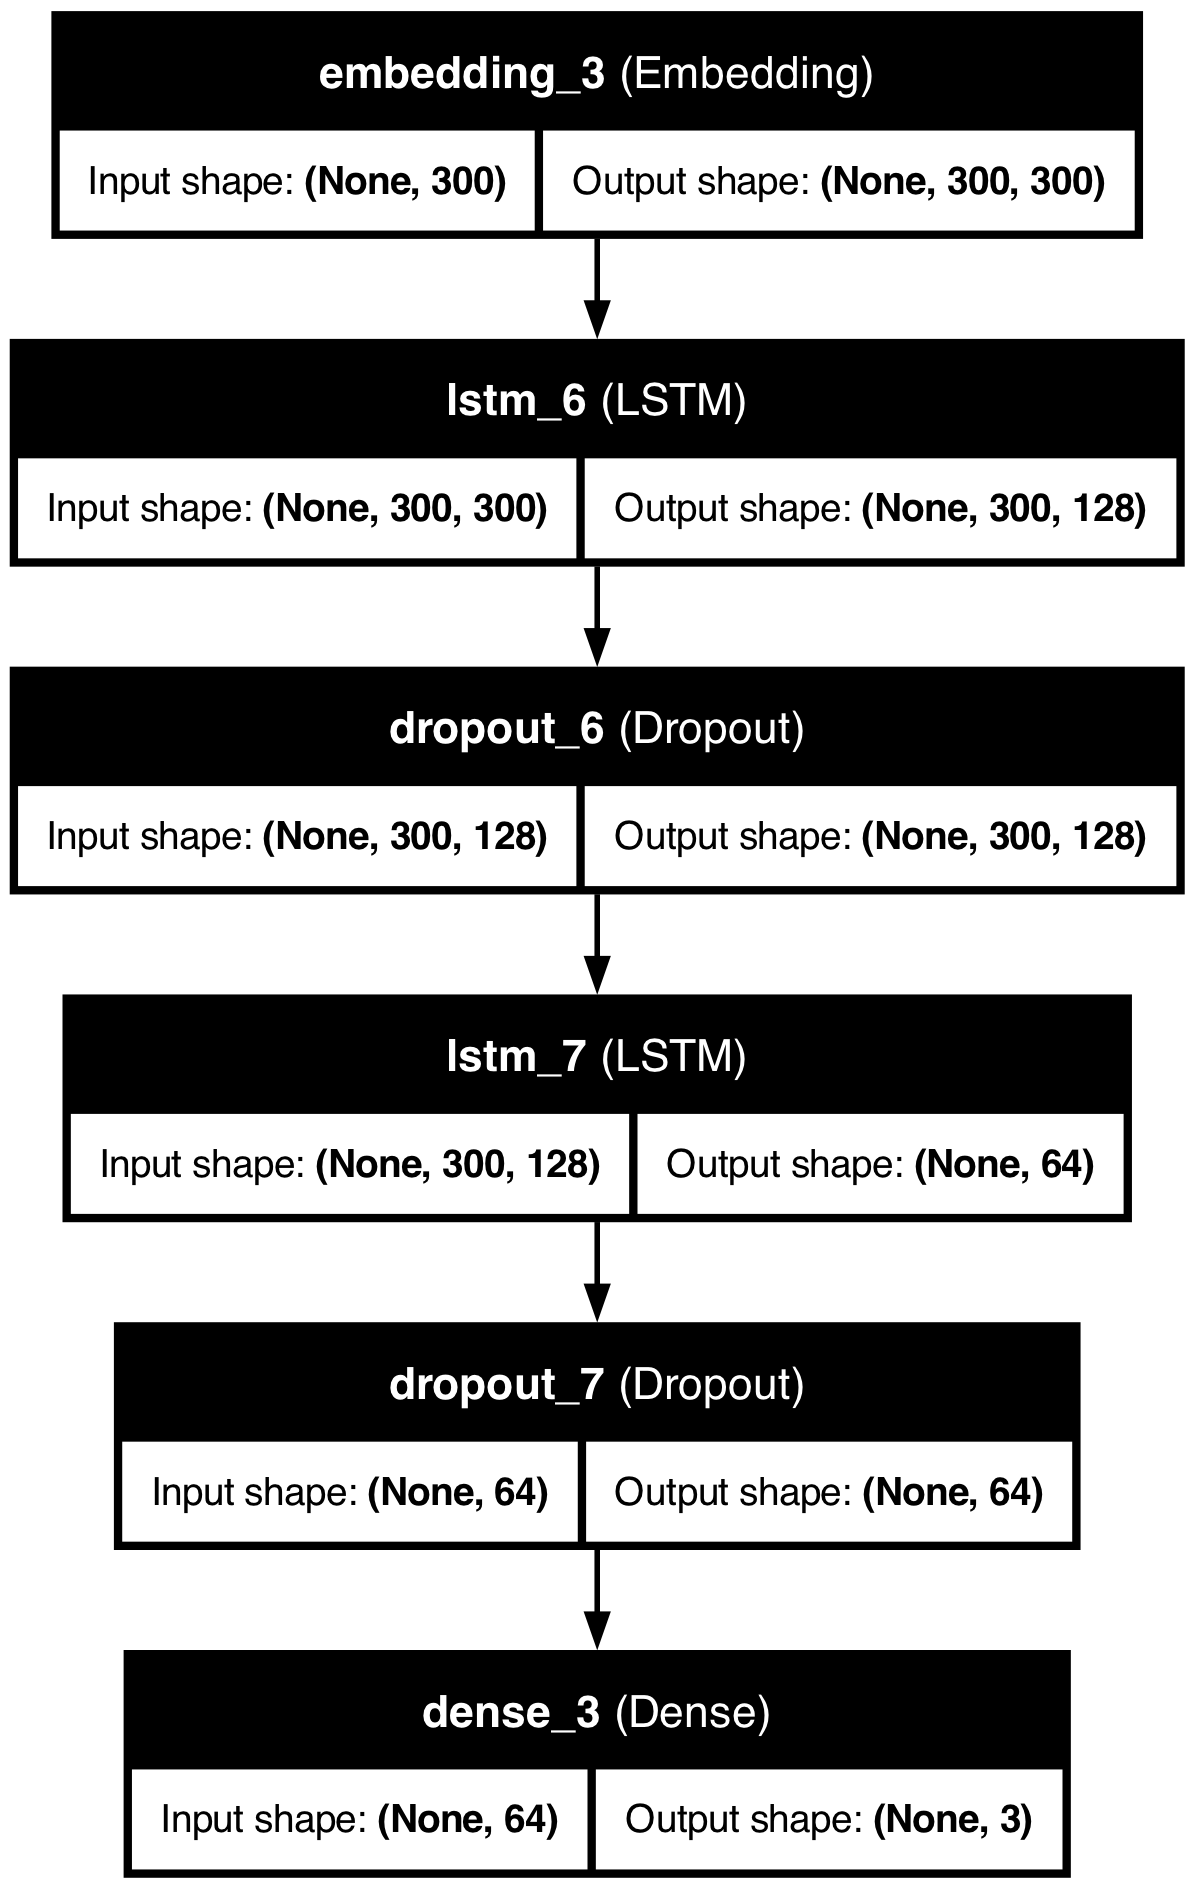

In [107]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [40]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# โหลดโมเดล LSTM ที่ดีที่สุด
best_model = load_model('../../models/LSTM_models_sample.keras')

In [43]:
validate_review_df = y_val

In [44]:
validate_review_df.sort_values(by='sentiment', ascending=True).head(10)

TypeError: Series.sort_values() got an unexpected keyword argument 'by'

In [45]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(validate_review_df['cleaned_review'])

X_val_resampled = tokenizer.texts_to_sequences(validate_review_df['cleaned_review'])
X_val_resampled = pad_sequences(X_val_resampled, maxlen=max_sequence_length)

y_val_resampled = validate_review_df['sentiment'].map(label_mapping)

KeyError: 'cleaned_review'

In [46]:
y_val_resampled.shape

NameError: name 'y_val_resampled' is not defined

In [145]:
X_val_resampled.shape

(5909, 300)

In [ ]:
# ใช้โมเดล LSTM ทำนายข้อมูล validation set
# lstm_preds = best_model.predict(X_val_resampled)
# lstm_preds = np.argmax(lstm_preds, axis=1)

# ฝึก Gradient Boosting Classifier บนผลลัพธ์จาก LSTM
# gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
# gb_clf.fit(lstm_preds.reshape(-1, 1), y_val_resampled)

# # ทำนายผลลัพธ์ด้วย Gradient Boosting
# ensemble_preds = gb_clf.predict(lstm_preds.reshape(-1, 1))

# ตรวจสอบผลลัพธ์
# print(classification_report(y_val_resampled, ensemble_preds))
# print(confusion_matrix(y_val_resampled, ensemble_preds))

In [ ]:
# สร้างโมเดล Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_val)

# สร้างโมเดล Gradient Boosting (Boosting)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_val)

# วัดผลลัพธ์ของแต่ละโมเดล
print("Random Forest Accuracy:", accuracy_score(y_val, rf_predictions))
print("Gradient Boosting Accuracy:", accuracy_score(y_val, gb_predictions))

In [117]:
# Ensemble วิธี Voting (Hard Voting)
from sklearn.ensemble import VotingClassifier

# รวมโมเดลทั้งสองด้วยการ Voting
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gb', gb_model)],
    voting='hard')

voting_model.fit(X_train_resampled, y_train_resampled)
voting_predictions = voting_model.predict(X_val)

# วัดผลลัพธ์จากการใช้ Voting
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.4108888888888889


In [49]:
X_val_resampled

NameError: name 'X_val_resampled' is not defined

In [148]:
y_val_resampled

0       2
3       2
4       2
5       2
6       2
       ..
5814    0
5859    0
5866    0
5867    0
5882    0
Name: sentiment, Length: 5909, dtype: int64

In [149]:
common_indices = y_val.index.intersection(review_df.index)
missing_indices = y_val.index.difference(review_df.index)
print(f"Common indices count: {len(common_indices)}")
print(f"Missing indices count: {len(missing_indices)}")

Common indices count: 1761
Missing indices count: 7239


In [150]:
predict_label = y_val_resampled

In [ ]:
# X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

conf_matrix = confusion_matrix(y_val, lstm_preds)

print("Accuracy:", accuracy_score(y_val, lstm_preds))
print(classification_report(y_val, lstm_preds))
print(conf_matrix)

132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step
Accuracy: 0.9497749348495618
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1453
           1       0.92      0.97      0.95      1374
           2       0.97      0.87      0.92      1394

    accuracy                           0.95      4221
   macro avg       0.95      0.95      0.95      4221
weighted avg       0.95      0.95      0.95      4221

[[1453    0    0]
 [   2 1338   34]
 [  61  115 1218]]


In [59]:
import plotly.graph_objects as go

class_names = ['Negative', 'Natural', 'Positive']

fig = go.Figure(data=go.Heatmap(
        z=conf_matrix,
        x=[f'Predicted {label}' for label in class_names],  # predicted labels
        y=[f'Actual {label}' for label in class_names],  # actual labels
        hoverongaps=False,
        colorscale='Blues'  # Customize colorscale as needed
    ))

# Update layout for better readability
fig.update_layout(
    title='Confusion Matrix for 3 Classes',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    font=dict(size=14)
)

# Show the plot
fig.show()

In [52]:
redicted_df = pd.DataFrame({'predicted': lstm_preds}, index=y_val.index)
    
    # Concatenate y_val and the new predicted_df to create a new DataFrame
predict_df = pd.concat([y_val, redicted_df], axis=1)

In [53]:
predict_df

,sentiment,predicted
5688,1,1
12728,1,1
4096,2,2
10216,1,1
2848,1,1
...,...,...
6870,1,1
6933,1,1
5664,1,1
973,1,1


In [54]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]

# Now you can safely use .loc with valid_y_val indices
filtered_reviews = review_df.loc[valid_y_val.index]

In [55]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
5688,0,15709019,842778540,"Had my 50th birthday here, paid for a VIP area...",50th Birthday Night Out,Friends getaway,5,Sugar Club Phuket,Samut Prakan,P03018341,joy,<OOV> <OOV> 50th birthday <OOV> paid <OOV> <OO...
4096,2,7797850,778052913,There are so many things to see her. Although ...,"Modern, fun and interesting",NONE,5,Wat Pahuaylad Temple,Phetchabun,P03014669,joy,<OOV> <OOV> <OOV> many things <OOV> see <OOV> ...
2848,6,3646467,946794528,This is the first place for me to actually vis...,The Wat I visited first and the first Thai wor...,Solo travel,5,Wat Pathum Wanaram,Nakhon Nayok,P03011368,joy,<OOV> <OOV> <OOV> first place <OOV> <OOV> <OOV...
4843,2,4743290,721908990,I took a tuk tuk from hotel near Railway Stati...,Worth a Look,NONE,3,City Pillar Shrine (Udon Thani),Bangkok,P03013204,joy,<OOV> took <OOV> tuk tuk <OOV> hotel near rail...
4653,2,669532,923163471,The animals are in tiny enclosures. \nGolf car...,Don’t go,Family,1,Khao Kheow Open Zoo,Bangkok,P03013450,joy,<OOV> animals <OOV> <OOV> tiny enclosures golf...
...,...,...,...,...,...,...,...,...,...,...,...,...
5328,0,456166,638095869,It looks like many Thai are motivated to do sp...,Like a pleasant garden,Solo travel,4,Romaneenart Park,Bangkok,P03013454,joy,<OOV> looks like many thai <OOV> motivated <OO...
5304,0,1639475,946727651,This museum showcased the history and culture ...,Interesting to learn about the history and cul...,Couples,5,Chiang Mai City Arts and Cultural Centre,Bangkok,P03013459,joy,<OOV> museum showcased <OOV> history <OOV> cul...
5397,0,4322638,723387240,Whilst the Chedi itself is am impressive struc...,Getting here is what makes it most interesting,Couples,4,Phra Samut Chedi,Samut Prakan,P03013499,joy,whilst <OOV> chedi <OOV> <OOV> <OOV> impressiv...
5664,0,14170166,883289021,Pirate tour\n\nMy husband booked this tour bef...,Great snorkelling experience,NONE,4,Phi Phi Island Boat Tours,Samut Prakan,P03018472,anger,pirate tour <OOV> husband booked <OOV> tour <O...


In [56]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'],
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted'], # The predicted sentiment labels
    'place_id': filtered_reviews['place_id'],
    'place_name': filtered_reviews['province'],
    'emotion': filtered_reviews['emotion'],
    'review_id': filtered_reviews['review_id']
})

# predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
# predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.tail(5)


,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
14049,NaN,NaN,NaN,NaN,NaN,NaN,2,0,NaN,NaN,NaN,NaN
14053,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
14057,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN
14065,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN
14066,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN


In [57]:
df_filtered = predictions_df.dropna()
df_filtered

,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment,place_id,place_name,emotion,review_id
0,2209612.0,Wat Ratchabophit,Family,5.0,0.0,Besides elegant grand palace and wat pra kaew ...,1,1,P03013220,Bangkok,joy,953596359.0
3,2209612.0,Wat Ratchabophit,Couples,5.0,0.0,Wat Ratchabophit is a Buddhist temple located ...,0,0,P03013220,Bangkok,joy,885904967.0
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,0,0,P03013220,Bangkok,love,738692369.0
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",2,2,P03013220,Bangkok,surprise,962482865.0
15,317504.0,Temple Of Dawn (Wat Arun),Couples,5.0,0.0,Probably the best temple in Bangkok.. given th...,0,0,P03013220,Bangkok,joy,962528316.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5900,7726805.0,Wat Prasat Temple,NONE,4.0,11.0,The size is not big. Pillars are well decorate...,2,2,P03013503,Nonthaburi,joy,877979960.0
5902,7726805.0,Wat Prasat Temple,Solo travel,5.0,1.0,Compared to the other temples in the local are...,2,2,P03013503,Nonthaburi,joy,658165922.0
5903,7726805.0,Wat Prasat Temple,Couples,4.0,0.0,Beautiful Lanna architecture and sacred Buddha...,1,1,P03013503,Nonthaburi,joy,591689577.0
5905,1831068.0,Prasat Puay Noi,NONE,3.0,4.0,Prasat Pueai Noi is claimed to be the biggest ...,1,1,P03013503,Nonthaburi,joy,752115552.0


In [58]:
df_filtered.to_csv('./output/LSTM_predictions.csv')

In [1]:
y_val = y_val.astype(int)
ensemble_preds_class = df_filtered.astype(int)


NameError: name 'y_val' is not defined

In [51]:
print(y_val.shape)            # Shape of y_val
print(ensemble_preds.shape) 

(1723,)
(1723,)


In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

NameError: name 'y_test' is not defined

In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264
